# **从深度学习角度探索加密货币市场订单簿的可预测性（使用JAX）**
本笔记本用于探索加密货币市场订单簿的可预测性。我们选择比特币是因为它是最广为人知的，因此也是流动性最好的。我们揭示了短期/中期可预测性的明确迹象。
### **数据**
我们使用BTCUSDT订单簿行情数据，该数据在[Tardis.dev](https://docs.tardis.dev/historical-data-details/binance)上公开提供每月第一天的数据。可以使用tardis-dev python库进行下载。
### **参考文献**
[1] Zhang Z, Zohren S, Roberts S. DeepLOB: Deep convolutional neural networks for limit order books. IEEE Transactions on Signal Processing. 2019 Mar 25. https://arxiv.org/abs/1808.03668
[2] Kolm, Petter N. and Turiel, Jeremy and Westray, Nicholas, Deep Order Flow Imbalance: Extracting Alpha at Multiple Horizons from the Limit Order Book. 2021 August 5. [https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3900141](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3900141)
[3] Lucchese L, S.Pankkanen M, E.D.Veraart A. THE SHORT-TERM PREDICTABILITY OF RETURNS IN ORDER BOOK MARKETS: A DEEP LEARNING PERSPECTIVE. 2023 Oct 10. [https://arxiv.org/pdf/2211.13777.pdf](https://arxiv.org/pdf/2211.13777.pdf)
[4] Dean Markwick. Order Flow Imbalance - A High Frequency Trading Signal. 2022 Feb 2. [https://dm13450.github.io/2022/02/02/Order-Flow-Imbalance.html](https://dm13450.github.io/2022/02/02/Order-Flow-Imbalance.html)

In [1]:
!pip install pandas tardis-dev tqdm pyarrow clu --quiet

In [2]:
from tardis_dev import datasets
from datetime import datetime
from dateutil.relativedelta import relativedelta
import nest_asyncio
nest_asyncio.apply()

today = datetime.now()
if today.day <= 2:
  today = today - relativedelta(months=1)

days = [datetime(today.year, today.month, 1) - i*relativedelta(months=1) for i in range(6)][::-1]

for day in days:
  datasets.download(
      exchange="binance",
      data_types=["book_ticker"],
      from_date=day.strftime("%Y-%m-%d"),
      to_date=(day+relativedelta(days=1)).strftime("%Y-%m-%d"),
      symbols=["BTCUSDT"])

file_paths = [f'datasets/binance_book_ticker_{day.strftime("%Y-%m-%d")}_BTCUSDT.csv.gz' for day in days]
file_paths

['datasets/binance_book_ticker_2025-01-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2025-02-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2025-03-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2025-04-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2025-05-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2025-06-01_BTCUSDT.csv.gz']

In [3]:
import pandas as pd
pd.set_option('display.max_columns', 100)

df = pd.concat([pd.read_csv(file_path, engine='pyarrow') for file_path in file_paths], axis=0)
df.drop(['local_timestamp'], axis=1, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
df.set_index('timestamp', inplace=True)
df

,exchange,symbol,ask_amount,ask_price,bid_price,bid_amount
timestamp,,,,,,
2025-01-01 00:00:00.015804,binance,BTCUSDT,3.52954,93576.01,93576.00,0.61022
2025-01-01 00:00:00.032096,binance,BTCUSDT,3.52884,93576.01,93576.00,0.61022
2025-01-01 00:00:00.032102,binance,BTCUSDT,3.52884,93576.01,93576.00,0.60952
2025-01-01 00:00:00.050148,binance,BTCUSDT,3.52904,93576.01,93576.00,0.60952
2025-01-01 00:00:00.077545,binance,BTCUSDT,3.52904,93576.01,93576.00,0.60586
...,...,...,...,...,...,...
2025-06-01 23:59:59.620148,binance,BTCUSDT,3.17542,105642.93,105642.92,1.56666
2025-06-01 23:59:59.718250,binance,BTCUSDT,3.17542,105642.93,105642.92,1.56671
2025-06-01 23:59:59.793237,binance,BTCUSDT,3.17438,105642.93,105642.92,1.56671


## **处理训练数据**
我们总共有2200万行数据，包含订单簿的第一层级。
数据将被处理并标记为：
  - 卖出（标签0）
  - 持有（标签1）
  - 买入（标签2）
一行数据的标签计算如下：
对于时间$t$的一行数据，我们记$b_t$和$a_t$为买入价和卖出价，定义时间$t$和时间窗口$h$下的卖出和买入回报为：
$$r_t^{\text{sell}} = \dfrac{b_t - \dfrac{1}{h}\sum_{s=1}^h a_{t+s}}{b_t};
r_t^{\text{buy}} = \dfrac{\dfrac{1}{h}\sum_{s=1}^h b_{t+s} - a_t}{a_t}$$
参数$h$是纯粹的临时参数，它代表前瞻窗口的大小。我们将尽量保持这些临时参数的数量尽可能少，以确保对训练数据的更好拟合能在真实市场环境中产生更高的准确性。
**解释**：如果我们在时间$t$卖出，$\dfrac{1}{h}\sum_{s=1}^h a_{t+s}$是未来h步内的平滑卖出价，我们希望这个值较低（例如价格下降），以便稍后以更好的价格买入。然后通过将这个平滑卖出回报与我们卖出的价格（$b_t$）进行加权来计算$r_t^{\text{sell}}$。
由于加密货币市场存在大量噪声和波动性，平滑处理是必要的，我们需要确保价格发生了显著变化才能将一行数据标记为买入或卖出。
这种$r$的定义与当前文献不同，在[3]中Lucchese等人仅使用中间价格来计算时间t的回报。
从我们的交易角度来看，我们必须只考虑可交易价格（即买入价和卖出价）
此外，价差（卖出价和买入价之间的差异）在高波动性期间可能激增至较大值，使得$m_t$成为真实市场状态的较差近似。
更多关于回报的定义在[3]中有探讨
然后我们引入$\gamma$，这是一行数据被标记为0或2的阈值。
如果$r_t^{\text{sell}} > \gamma$，一行数据被标记为0（卖出），如果$r_t^{\text{buy}} > \gamma$被标记为2（买入），否则该行被标记为1（持有）。
**将gamma设置为0将使一行数据当且仅当未来h步的平滑买入价超过价差时被标记为买入（即我们在盈利）。**
标记的行数据经过进一步处理，包括买入量和卖出量的标准化。此外，买入价和卖出价被替换为加权价差。这三个特征——标准化买入量、标准化卖出量和加权价差——构成了训练数据。

In [4]:
def process_data(temp_df, h, gamma, T):
  """
  :param temp_df: 数据框
  :param h: 前瞻窗口，看未来h个tick来决定标签
  :param gamma: 收益率阈值，0表示只要能覆盖价差就产生信号
  :param T: 输入序列长度，每个样本包含T个连续tick
  :return: 训练数据
  """
  print('from', temp_df.index[0], 'to', temp_df.index[-1])
  temp_df.reset_index(drop=True, inplace=True)

  # 买入信号识别
  # 步骤分解：
  # 1. temp_df['bid_price'].iloc[::-1]  # 价格序列反转
  # 2. .rolling(window=h).sum()/h       # 计算移动平均（窗口=50）
  # 3. .shift(1)                        # 向前移动1位
  # 4. .iloc[::-1]                      # 再次反转回原顺序
  # 这实际上计算的是：未来h个tick的平均买价
  # 买入收益率 = (未来平均买价 - 当前卖价) / 当前卖价
  # 如果 r_buy > gamma(0)，标记为买入点
  temp_buy_index = pd.Series(temp_df[((temp_df['bid_price'].iloc[::-1].rolling(window=h).sum()/h).shift(1).iloc[::-1] - temp_df['ask_price']) / temp_df['ask_price'] > gamma].index)

  temp_sell_index = pd.Series(temp_df[(temp_df['bid_price'] - (temp_df['ask_price'].iloc[::-1].rolling(window=h).sum()/h).shift(1)) / temp_df['bid_price'] > gamma].index)

  temp_df.loc[:, 'spread'] = 2 * (temp_df['ask_price'] - temp_df['bid_price']) / (temp_df['ask_price'] + temp_df['bid_price'])
  temp_df[['bid_amount', 'ask_amount']] = temp_df[['bid_amount', 'ask_amount']].div(temp_df[['bid_amount', 'ask_amount']].sum(axis=1), axis=0)

  temp_buy_points = temp_buy_index[temp_buy_index.diff(-1) != -1]
  temp_sell_points = temp_sell_index[temp_sell_index.diff(-1) != -1]

  temp_buy_windows = np.stack([temp_buy_points - t for t in range(T)]).T[:, ::-1]
  temp_sell_windows = np.stack([temp_sell_points - t for t in range(T)]).T[:, ::-1]

  temp_buys = temp_df.values[:, 2:][temp_buy_windows]
  temp_sells = temp_df.values[:, 2:][temp_sell_windows]

  temp_N = min(len(temp_buys), len(temp_sells))

  temp_hold_index = np.random.choice(temp_df.index.difference(temp_buy_index).difference(temp_sell_index), size=temp_N)
  temp_hold_windows = np.stack([temp_hold_index - t for t in range(T)]).T[:, ::-1]
  temp_holds = temp_df.values[:, 2:][temp_hold_windows]

  temp_buys = temp_buys[np.random.choice(temp_buys.shape[0], temp_N, replace=False)]
  temp_sells = temp_sells[np.random.choice(temp_sells.shape[0], temp_N, replace=False)]

  print(temp_buys.shape[0], 'buys')
  print(temp_holds.shape[0], 'holds')
  print(temp_sells.shape[0], 'sells', end='\n\n')

  temp_books = np.vstack((temp_buys, temp_holds, temp_sells))
  temp_labels = np.array([2]*temp_buys.shape[0]+[1]*temp_holds.shape[0]+[0]*temp_sells.shape[0])

  temp_ds = {'book': jnp.array(temp_books),
              'label': jnp.array(temp_labels)}
  return temp_ds

## **神经网络**
与当前文献保持一致，我们使用CNN来有效捕获订单簿特征中的模式，从而预测市场变化。
我们使用Flax和JAX编写一个通用的CNN，其超参数可以高效地更改和调整。

In [7]:
from flax import linen as nn
from flax.training import train_state
import jax
import jax.numpy as jnp
import numpy as np
import optax
from tqdm import tqdm, trange
from clu import parameter_overview
from typing import Any
import pandas as pd
from datetime import datetime

class TrainState(train_state.TrainState):
  batch_stats: Any

class CNN(nn.Module):
    """CNN Model"""
    kernel_size_1: int
    kernel_size_2: int
    kernel_size_3: int
    padding: str
    features: int
    dense: int
    activation: str

    @nn.compact
    def __call__(self, x, train):
        x = nn.Conv(features=2**self.features,
                    kernel_size=(1, self.kernel_size_1))(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = eval(f"nn.{self.activation}(x)")
        x = nn.Conv(features=2**self.features,
                    kernel_size=(self.kernel_size_2, 1),
                    padding=self.padding)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = eval(f"nn.{self.activation}(x)")
        x = nn.Conv(features=2**self.features,
                    kernel_size=(self.kernel_size_3, 1),
                    padding=self.padding)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = eval(f"nn.{self.activation}(x)")

        x = x.reshape((x.shape[0], -1))

        x = nn.Dense(features=2**self.dense)(x)
        x = eval(f"nn.{self.activation}(x)")

        x = nn.Dense(features=3)(x) # buy, hold or sell
        return x

@jax.jit
def apply_model(state, books, labels):
  """Computes gradients, loss and accuracy for a single batch."""

  def loss_fn(params):
    logits, updates = state.apply_fn({'params': params, 'batch_stats': state.batch_stats},
                                     books,
                                     train=True,
                                     mutable=['batch_stats'])
    one_hot = jax.nn.one_hot(labels, 3)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, (logits, updates)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (logits, updates)), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, updates, loss, accuracy

@jax.jit
def update_model(state, grads, updates):
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])
  return state

def train_epoch(state, train_ds, batch_size, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['book'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['book']))
  perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []
  epoch_accuracy = []

  for perm in tqdm(perms):
    batch_books = train_ds['book'][perm, ...]
    batch_labels = train_ds['label'][perm, ...]
    grads, updates, loss, accuracy = apply_model(state, batch_books, batch_labels)
    state = update_model(state, grads, updates)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy


def create_train_state(rng, optimizer, learning_rate, T, hparams) -> TrainState:
  """Creates initial `TrainState`."""
  cnn = CNN(**hparams)
  variables = cnn.init(rng, jnp.ones([1, T, 3]), train=False)
  print(parameter_overview.get_parameter_overview(variables))
  params = variables['params']
  batch_stats = variables['batch_stats']
  tx = eval(f"optax.{optimizer}({learning_rate})")
  return TrainState.create(apply_fn=cnn.apply, params=params, tx=tx, batch_stats=batch_stats)


def train_and_evaluate(h, gamma, T, optimizer, learning_rate, batch_size, num_epochs, hparams) -> TrainState:
  """Execute model training and evaluation loop.

  Returns:
    The train state (which includes the `.params`).
  """

  print("Training data:")
  train_df = pd.concat([pd.read_csv(train_file_path, usecols=['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount'], engine='pyarrow') for train_file_path in file_paths[:-1]], axis=0)
  train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], unit='us')
  train_df.set_index('timestamp', inplace=True)
  train_ds = process_data(train_df, h=h, gamma=gamma, T=T)

  print("Test data:")
  test_df = pd.read_csv(file_paths[-1], usecols=['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount'], engine='pyarrow')
  test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='us')
  test_df.set_index('timestamp', inplace=True)
  test_ds = process_data(test_df, h=h, gamma=gamma, T=T)

  # assert 'cuda' in str(train_ds['book'].devices())

  print("Training on shape", train_ds["book"].shape, train_ds['label'].shape)
  print("Testing on shape", test_ds["book"].shape, test_ds['label'].shape)

  rng = jax.random.key(0)
  rng, init_rng = jax.random.split(rng)

  state = create_train_state(init_rng, optimizer, learning_rate, T, hparams)
  for epoch in range(1, num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(state, train_ds, batch_size, input_rng)
    _, _, test_loss, test_accuracy = apply_model(state, test_ds['book'], test_ds['label'])
    print('epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f,'
          ' test_accuracy: %.2f,' % (epoch,
                                    train_loss,
                                    train_accuracy * 100,
                                    test_loss,
                                    test_accuracy * 100))
  return state

## **超参数**
超参数是通过使用[Optuna](https://optuna.readthedocs.io/en/stable/index.html)进行广泛的超参数调优研究得出的。
有关JAX中超参数调优的更多信息，请参见[指南4：使用JAX进行研究项目](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide4/Research_Projects_with_JAX.html)

In [8]:
h = 50
gamma = 0
T = 10

num_epochs = 10
learning_rate = 0.03
batch_size = 1024

hparams = {'kernel_size_1': 1,
         'kernel_size_2': 5,
         'kernel_size_3': 8,
         'padding': 'SAME',
         'features': 6,
         'dense': 9,
         'activation': 'hard_swish'}

optimizer = "novograd"

state = train_and_evaluate(h, gamma, T, optimizer, learning_rate, batch_size, num_epochs, hparams)

Training data:
from 2025-01-01 00:00:00.015804 to 2025-05-01 23:59:59.618020
102885 buys
102885 holds
102885 sells

Test data:
from 2025-06-01 00:00:00.005143 to 2025-06-01 23:59:59.806193
9300 buys
9300 holds
9300 sells

Training on shape (308655, 10, 3) (308655,)
Testing on shape (27900, 10, 3) (27900,)
+------------------------------+----------------+---------+---------+-----------+--------+
| Name                         | Shape          | Dtype   | Size    | Mean      | Std    |
+------------------------------+----------------+---------+---------+-----------+--------+
| batch_stats/BatchNorm_0/mean | (64,)          | float32 | 64      | 0.0       | 0.0    |
| batch_stats/BatchNorm_0/var  | (64,)          | float32 | 64      | 1.0       | 0.0    |
| batch_stats/BatchNorm_1/mean | (64,)          | float32 | 64      | 0.0       | 0.0    |
| batch_stats/BatchNorm_1/var  | (64,)          | float32 | 64      | 1.0       | 0.0    |
| batch_stats/BatchNorm_2/mean | (64,)          | float3

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:06<00:00, 46.99it/s]


epoch:  1, train_loss: 0.4618, train_accuracy: 83.09, test_loss: 0.3928, test_accuracy: 88.03,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 51.17it/s]


epoch:  2, train_loss: 0.4057, train_accuracy: 85.95, test_loss: 0.3564, test_accuracy: 88.19,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 51.85it/s]


epoch:  3, train_loss: 0.3992, train_accuracy: 86.22, test_loss: 0.3492, test_accuracy: 88.86,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 52.60it/s]


epoch:  4, train_loss: 0.3927, train_accuracy: 86.43, test_loss: 0.3426, test_accuracy: 88.85,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 52.55it/s]


epoch:  5, train_loss: 0.3909, train_accuracy: 86.48, test_loss: 0.3303, test_accuracy: 89.12,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 51.55it/s]


epoch:  6, train_loss: 0.3899, train_accuracy: 86.49, test_loss: 0.3405, test_accuracy: 89.04,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 51.01it/s]


epoch:  7, train_loss: 0.3875, train_accuracy: 86.60, test_loss: 0.3398, test_accuracy: 88.97,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 51.60it/s]


epoch:  8, train_loss: 0.3854, train_accuracy: 86.69, test_loss: 0.3242, test_accuracy: 89.36,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 51.25it/s]


epoch:  9, train_loss: 0.3849, train_accuracy: 86.72, test_loss: 0.3286, test_accuracy: 89.46,


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:05<00:00, 51.29it/s]


epoch: 10, train_loss: 0.3868, train_accuracy: 86.55, test_loss: 0.3209, test_accuracy: 89.64,


## **评估**
一旦我们有了一个准确的模型，我们就可以在未见过的测试数据集上评估该模型，并计算每行数据的预测结果。

In [9]:
def evaluate(state, T, test_df, test_batch_size):
    preds = pd.DataFrame(index=test_df.index, columns=['sell', 'hold' ,'buy'])
    sliding_view = jnp.array(np.lib.stride_tricks.sliding_window_view(test_df.values, (T, 5)).reshape(-1, T, 5))
    for k in trange(0, sliding_view.shape[0], test_batch_size):
        test_batch = sliding_view[k: k+test_batch_size, :, 2:]
        logits, _ = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, test_batch, train=False, rngs={'dropout': jax.random.key(1)}, mutable=['batch_stats'])
        class_probabilities = jax.nn.softmax(logits)
        preds.iloc[k+T-1: k+T-1+class_probabilities.shape[0]] = class_probabilities
    return preds

In [10]:
test_df = pd.read_csv(file_paths[-1], usecols=['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount'], engine='pyarrow')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='us')
test_df.set_index('timestamp', inplace=True)
test_df.loc[:, 'spread'] = 2 * (test_df['ask_price'] - test_df['bid_price']) / (test_df['ask_price'] + test_df['bid_price'])
test_df[['bid_amount', 'ask_amount']] = test_df[['bid_amount', 'ask_amount']].div(test_df[['bid_amount', 'ask_amount']].sum(axis=1), axis=0)
test_batch_size = 2048*8

预测结果是一个三元组[sell_confidence, hold_confidence, buy_confidence]，取值范围为[0, 1]，我们将预测结果记录在一个单独的数据框中：
前T-1行没有预测结果，因为我们需要最后T行数据来输入到模型中

In [11]:
preds = evaluate(state, T, test_df, test_batch_size)
preds

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 460/460 [00:44<00:00, 10.26it/s]


,sell,hold,buy
timestamp,,,
2025-06-01 00:00:00.005143,NaN,NaN,NaN
2025-06-01 00:00:00.011174,NaN,NaN,NaN
2025-06-01 00:00:00.019050,NaN,NaN,NaN
2025-06-01 00:00:00.023041,NaN,NaN,NaN
2025-06-01 00:00:00.219430,NaN,NaN,NaN
...,...,...,...
2025-06-01 23:59:59.620148,0.015562,0.952937,0.031501
2025-06-01 23:59:59.718250,0.015547,0.947979,0.036474
2025-06-01 23:59:59.793237,0.01334,0.958269,0.028392


现在我们将基于预测结果实施一个交易策略。
我们编写一个通用函数来获取买入/卖出预测的相关价格和数量。
从实际市场应用的角度来看，我们考虑了从接收订单簿更新到我们的订单实际在交易所成交之间的延迟。
币安提供了一个代码片段来直接计算您与市场之间的延迟：[https://github.com/binance/binance-toolbox-python/blob/master/check_order_update_latency.py](https://github.com/binance/binance-toolbox-python/blob/master/check_order_update_latency.py)
币安的websocket服务器位于东京，我们使用位于该地区的AWS虚拟机来获得最低延迟，我们得到的结果是接收订单簿更新大约需要4毫秒，然后模型运行推理大约需要37毫秒，根据我们的测试，我们的订单提交和成交需要3毫秒。
这使得总延迟约为45毫秒，这在高频交易领域是非常普通的。我们面临着以比我们看到的报价更高或更低的价格买入或卖出的风险。高频交易的黄金标准约为200纳秒。
此外，我们假设我们的活动不会影响市场，如果我们开始大量交易，这个假设是有争议的

In [12]:
%timeit state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, jnp.ones([1, T, 3]), train=False, mutable=['batch_stats'])

6.01 ms ± 45.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
def compute_prices(test_df, preds, latency=pd.Timedelta(milliseconds=50), confidences=np.linspace(1/3, 1, 10)):
    pred_df = pd.concat([test_df, preds], axis=1)
    conf_df = test_df.copy()
    for confidence in confidences:
        labels = pd.Series([1]*len(test_df.index), index=test_df.index, name=f'label_{round(confidence, 2)}', dtype=np.uint) # hold everything
        labels[preds.max(axis=1) > confidence] = np.argmax(preds.values, axis=1)[preds.max(axis=1) > confidence]
        conf_df = pd.concat([conf_df, labels], axis=1)

    df_temp = conf_df.copy()
    df_temp.index = df_temp.index - latency

    # Perform an asof merge to get the last price and amount at time timestamp + latency for each timestamp, direction backward to trade at the current market state after latency
    df_merged = pd.merge_asof(conf_df, df_temp[['bid_price', 'ask_price', 'bid_amount', 'ask_amount']], left_index=True, right_index=True, suffixes=('', '_future'), direction="backward")

    df_merged.drop(['ask_price', 'ask_amount', 'bid_price', 'bid_amount'], inplace=True, axis=1)
    return df_merged

In [14]:
test_df = pd.read_csv(file_paths[-1], usecols=['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount'], engine='pyarrow')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='us')
test_df.set_index('timestamp', inplace=True)

In [15]:
prices = compute_prices(test_df, preds)
prices

,label_0.33,label_0.41,label_0.48,label_0.56,label_0.63,label_0.7,label_0.78,label_0.85,label_0.93,label_1.0,bid_price_future,ask_price_future,bid_amount_future,ask_amount_future
timestamp,,,,,,,,,,,,,,
2025-06-01 00:00:00.005143,1,1,1,1,1,1,1,1,1,1,104591.88,104591.89,4.96873,2.91009
2025-06-01 00:00:00.011174,1,1,1,1,1,1,1,1,1,1,104591.88,104591.89,4.96873,2.91009
2025-06-01 00:00:00.019050,1,1,1,1,1,1,1,1,1,1,104591.88,104591.89,4.96873,2.91009
2025-06-01 00:00:00.023041,1,1,1,1,1,1,1,1,1,1,104591.88,104591.89,4.96873,2.91009
2025-06-01 00:00:00.219430,1,1,1,1,1,1,1,1,1,1,104591.88,104591.89,4.96868,2.91009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-01 23:59:59.620148,1,1,1,1,1,1,1,1,1,1,105642.92,105642.93,1.56666,3.17542
2025-06-01 23:59:59.718250,1,1,1,1,1,1,1,1,1,1,105642.92,105642.93,1.56671,3.17542
2025-06-01 23:59:59.793237,1,1,1,1,1,1,1,1,1,1,105642.92,105642.93,1.56668,3.17438


In [16]:
def compute_trades(prices):
  trades = {}
  for label_column in prices.filter(regex=r'label_').columns:
    confidence = float(label_column.split('_')[-1])
    conf_df = prices[[label_column, 'bid_price_future', 'ask_price_future', 'bid_amount_future', 'ask_amount_future']].copy()

    conf_df = conf_df[conf_df[label_column] != 1].dropna() # remove holds

    # Remove consecutive duplicate labels
    conf_df['group'] = (conf_df[label_column] != conf_df[label_column].shift()).cumsum()
    conf_df = conf_df.drop_duplicates(subset='group')
    conf_df.drop(columns='group', inplace=True)

    conf_df.loc[conf_df[label_column] == 2, 'price_future'] = - conf_df.loc[conf_df[label_column] == 2, 'ask_price_future']
    conf_df.loc[conf_df[label_column] == 0, 'price_future'] = conf_df.loc[conf_df[label_column] == 0, 'bid_price_future']
    conf_df.loc[conf_df[label_column] == 2, 'amount_future'] = conf_df.loc[conf_df[label_column] == 2, 'ask_amount_future']
    conf_df.loc[conf_df[label_column] == 0, 'amount_future'] = conf_df.loc[conf_df[label_column] == 0, 'bid_amount_future']

    conf_df.drop(['bid_price_future', 'ask_price_future', 'bid_amount_future', 'ask_amount_future'], inplace=True, axis=1)
    trades[confidence] = conf_df.copy()

  return trades

In [17]:
trades = compute_trades(prices)
next(iter(trades.values()))

,label_0.33,price_future,amount_future
timestamp,,,
2025-06-01 00:00:05.558608,2,-104634.15,0.25263
2025-06-01 00:00:05.579252,0,104634.14,5.09582
2025-06-01 00:00:05.579274,2,-104634.15,0.25263
2025-06-01 00:00:05.580751,0,104634.14,5.09588
2025-06-01 00:00:05.580753,2,-104634.15,0.25263
...,...,...,...
2025-06-01 23:59:21.479222,2,-105629.16,0.00005
2025-06-01 23:59:21.479223,0,105629.15,0.00010
2025-06-01 23:59:21.578274,2,-105629.20,0.59762


对于每个置信度，我们都有标签以及延迟后每个信号的价格和可用数量
## **交易策略**
将交易策略定义为一个可预测的过程，由每个时间戳n的金额(BTC_wallet, USDT_wallet)_n给出。
更新的市场价格由(price, 1)_n给出
如果对于每个n满足以下条件，则称交易策略为自筹资金的：
```
BTC_wallet_n * price_n + USDT_wallet_n = BTC_wallet_(n+1) * price_n + USDT_wallet_(n+1)
```
这意味着在时间n+1时钱包组成的修改只是时间n时钱包组成的重新安排。没有额外资金，也没有提取。
这意味着我们在过程中赚的钱越多，我们交易的钱就越多，从而导致我们钱包价值的指数增长。
记住指数也可能下降（非常快...）
我们采用的策略是自筹资金的，并验证我们的钱包价值始终非负。这样的策略称为合格策略。这意味着我们不会因使用它而负债，但我们可能会失去所有资金。
从空钱包开始并产生正利润的合格策略是套利。这是在不承担任何风险的情况下获利
如[4]中所述，我们计算策略的夏普比率(SR)，这个指标是回报的期望值除以回报的标准差，它衡量我们的策略相对于产生的利润有多大风险。
人们通常要求夏普比率至少超过1，这意味着结果的期望值大于回报的方差。

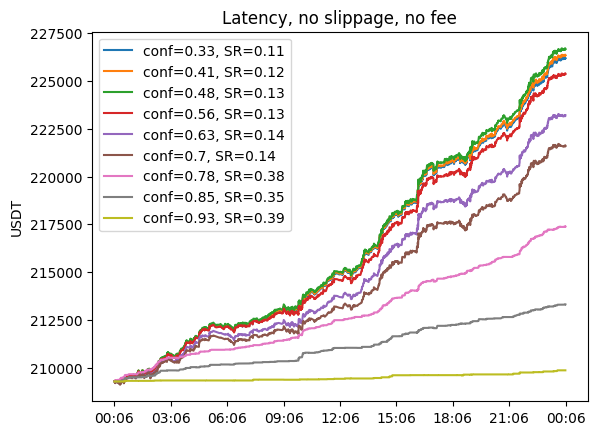

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

for confidence, trade in trades.items():
  if len(trade) <= 4: continue
  BTC_wallet = 1
  USDT_wallet = abs(trade.iloc[0]['price_future'])
  wallets = []
  for timestamp, (label, price, amount) in trade.iterrows():
    amount = 1 # ignoring slippage
    if label == 0:
      trade_amount = min(BTC_wallet, amount)
      BTC_wallet -= trade_amount
      USDT_wallet += price*trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
    if label == 2:
      price *= -1
      trade_amount = min(USDT_wallet, price*amount)
      BTC_wallet += trade_amount/price
      USDT_wallet -= trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
  wallets = np.array(wallets)
  diffs = np.diff(wallets[:, 1])
  plt.plot(wallets[:, 0], wallets[:, 1], label=f'conf={confidence}, SR={round(diffs.mean()/diffs.std(), 2)}')
plt.title("Latency, no slippage, no fee")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%m'))
plt.ylabel("USDT")
plt.legend()
plt.show()

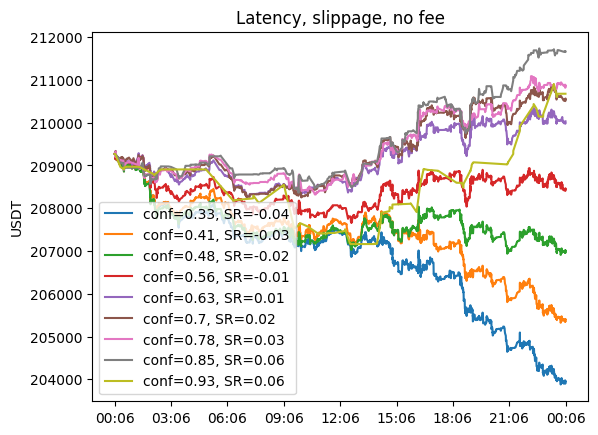

In [19]:
for confidence, trade in trades.items():
  if not len(trade): continue
  BTC_wallet = 1
  USDT_wallet = abs(trade.iloc[0]['price_future'])
  wallets = []
  for timestamp, (label, price, amount) in trade.iterrows():
    if label == 0:
      trade_amount = min(BTC_wallet, amount) # slippage
      BTC_wallet -= trade_amount
      USDT_wallet += price*trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
    if label == 2:
      price *= -1
      trade_amount = min(USDT_wallet, price*amount) # slippage
      BTC_wallet += trade_amount/price
      USDT_wallet -= trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
  wallets = np.array(wallets)
  diffs = np.diff(wallets[:, 1])
  plt.plot(wallets[:, 0], wallets[:, 1], label=f'conf={confidence}, SR={round(diffs.mean()/diffs.std(), 2)}')
plt.title("Latency, slippage, no fee")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%m'))
plt.ylabel("USDT")
plt.legend()
plt.show()

Still winnning

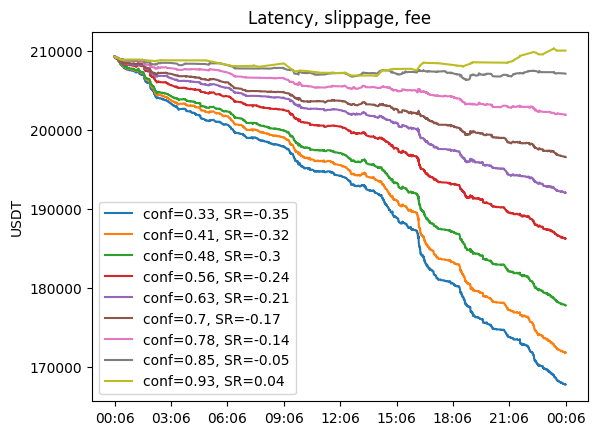

In [20]:
maker_fee = 0.0090/100 # https://www.binance.com/en/fee/trading
taker_fee = 2*maker_fee
for confidence, trade in trades.items():
  if not len(trade): continue
  BTC_wallet = 1
  USDT_wallet = abs(trade.iloc[0]['price_future'])
  wallets = []
  for timestamp, (label, price, amount) in trade.iterrows():
    if label == 0:
      trade_amount = min(BTC_wallet, amount)
      BTC_wallet -= trade_amount
      USDT_wallet += price*trade_amount*(1-taker_fee) # taker fee
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
    if label == 2:
      price *= -1
      trade_amount = min(USDT_wallet, price*amount)
      BTC_wallet += trade_amount/price*(1-maker_fee) # maker fee
      USDT_wallet -= trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
  wallets = np.array(wallets)
  diffs = np.diff(wallets[:, 1])
  plt.plot(wallets[:, 0], wallets[:, 1], label=f'conf={confidence}, SR={round(diffs.mean()/diffs.std(), 2)}')
plt.title("Latency, slippage, fee")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%m'))
plt.ylabel("USDT")
plt.legend()
plt.show()